## Style Transfer .

In [207]:
from glob import glob
from PIL import Image
import numpy as np

from scipy.optimize import fmin_l_bfgs_b
from scipy.optimize import minimize
from scipy.misc import imsave

import matplotlib.pyplot as plt

from keras import metrics

from keras.models import Model
from keras.layers import Flatten,Dense,Input
from keras.layers import Convolution2D,AveragePooling2D
from keras.utils.data_utils import get_file
from keras import backend as K

from keras.applications.imagenet_utils import decode_predictions, preprocess_input, _obtain_input_shape

In [61]:
#Get Pretrain weight for vgg network with out dense layer
TF_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [112]:
#get all the images in folder
fnames = glob('**/*.png',recursive=True)
fnames.extend( glob('**/*.jpg',recursive=True))
fnames

['results\\abc.png',
 'results\\res2_0_5.png',
 'results\\res2_0_9.png',
 'results\\res2_10_5.png',
 'results\\res2_10_9.png',
 'results\\res2_11_5.png',
 'results\\res2_11_9.png',
 'results\\res2_12_5.png',
 'results\\res2_12_9.png',
 'results\\res2_13_5.png',
 'results\\res2_13_9.png',
 'results\\res2_14_5.png',
 'results\\res2_14_9.png',
 'results\\res2_15_5.png',
 'results\\res2_15_9.png',
 'results\\res2_16_5.png',
 'results\\res2_16_9.png',
 'results\\res2_17_5.png',
 'results\\res2_17_9.png',
 'results\\res2_18_5.png',
 'results\\res2_18_9.png',
 'results\\res2_19_5 - Copy.png',
 'results\\res2_19_5.png',
 'results\\res2_19_9 - Copy.png',
 'results\\res2_19_9.png',
 'results\\res2_1_5.png',
 'results\\res2_1_9.png',
 'results\\res2_2_5.png',
 'results\\res2_2_9.png',
 'results\\res2_3_5.png',
 'results\\res2_3_9.png',
 'results\\res2_4_5.png',
 'results\\res2_4_9.png',
 'results\\res2_5_5.png',
 'results\\res2_5_9.png',
 'results\\res2_6_5.png',
 'results\\res2_6_9.png',
 'resul

In [113]:
#load content image and style image

ref_img = Image.open(fnames[-4])
ref_img = ref_img.resize((256, 256), Image.ANTIALIAS)
style_img = Image.open(fnames[-3])
style_img = style_img.resize((256, 256), Image.ANTIALIAS)

#ref_img = ref_img.resize(np.divide(ref_img.size,3).astype('int32'))
#style_img = style_img.resize(np.divide(style_img.size,3).astype('int32'))

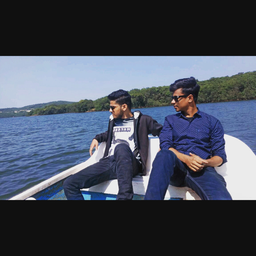

In [114]:
ref_img

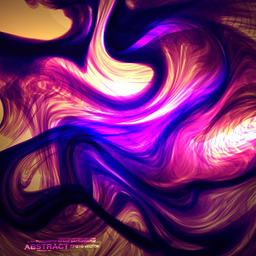

In [115]:
style_img

In [116]:
#subtract mean from image for vgg network input
rn_mean =np.array([123.86,116.779,103.939],dtype=np.float32)
preproc = lambda x:(x-rn_mean)[:,:,:,::-1]

In [117]:
# add mean again to image to get original image
deproc = lambda x,s:np.clip(x.reshape(s)[:,:,:,::-1]+rn_mean,0,255)

In [118]:
source = preproc(np.expand_dims(np.array(ref_img),0))
shp = source.shape

style_ = preproc(np.expand_dims(np.array(style_img),0))
style_shp = style_.shape


In [119]:
#re creating vgg architecture 
#in this network we have use average pooling instead we max pooling 
#we want to save as much as posible data

def Vgg16_Avg(inp=None,inp_shape=None):
    
    
    input_shape = _obtain_input_shape(inp_shape,
                                      default_size=224,
                                      min_size=48,
                                      dim_ordering=K.image_dim_ordering(),
                                      include_top=False)
    layers = []
    
    
    if inp is None:
        img_inp = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(inp):
            img_inp = Input(tensor=inp, shape=input_shape)
        else:
            img_inp = input_tensor
    
    #first block
    x = Convolution2D(64,3,3, activation='relu',border_mode='same',name='block1_conv1')(img_inp)
    x = Convolution2D(64,3,3, activation='relu',border_mode ='same',name='block1_conv2')(x)
    x = AveragePooling2D((2,2),strides=(2,2),name='block1_pool')(x)
    
    #second block
    x = Convolution2D(128,3,3, activation='relu',border_mode='same',name='block2_conv1')(x)
    x = Convolution2D(128,3,3, activation='relu',border_mode ='same',name='block2_conv2')(x)
    x = AveragePooling2D((2,2),strides=(2,2),name='block2_pool')(x)
    
    #third block
    x = Convolution2D(256,3,3, activation='relu',border_mode='same',name='block3_conv1')(x)
    x = Convolution2D(256,3,3, activation='relu',border_mode ='same',name='block3_conv2')(x)
    x = Convolution2D(256,3,3, activation='relu',border_mode ='same',name='block3_conv3')(x)
    x = AveragePooling2D((2,2),strides=(2,2),name='block3_pool')(x)
    
    #fourth block
    x = Convolution2D(512,3,3, activation='relu',border_mode='same',name='block4_conv1')(x)
    x = Convolution2D(512,3,3, activation='relu',border_mode ='same',name='block4_conv2')(x)
    x = Convolution2D(512,3,3, activation='relu',border_mode ='same',name='block4_conv3')(x)
    x = AveragePooling2D((2,2),strides=(2,2),name='block4_pool')(x)
    
    #fifth block
    x = Convolution2D(512,3,3, activation='relu',border_mode='same',name='block5_conv1')(x)
    x = Convolution2D(512,3,3, activation='relu',border_mode ='same',name='block5_conv2')(x)
    x = Convolution2D(512,3,3, activation='relu',border_mode ='same',name='block5_conv3')(x)
    x = AveragePooling2D((2,2),strides=(2,2),name='block5_pool')(x)
    
    #download weights and load it to our network
    weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',TF_WEIGHTS_PATH_NO_TOP,cache_subdir='models')
    
    if inp is not None:
        inputs = get_source_inputs(inp)
    else:
        inputs = img_inp
    model = Model(inputs,x,name='vgg16')
    model.load_weights(weights_path)
    
    return model
    

In [120]:
model = Vgg16_Avg()

In [121]:
#separate gradient and loss
class Evaluator(object):
    def __init__(self,f,shp):
        self.f,self.shp = f,shp
    def loss(self,x):
        loss_,self.grad_values = self.f([x.reshape(self.shp)])
        return loss_
    def grads(self,x):
        return self.grad_values.flatten().astype(np.float64)

In [166]:
#optimizer for our network to improve input image
def solve_image(eval_obj,n,x,types):
    for i in range(n):
        x,min_val,info = fmin_l_bfgs_b(eval_obj.loss,x.flatten(),fprime=eval_obj.grads,maxfun=20)
        x = np.clip(x,-127,127)
        print('Current loss: ',min_val)
        imsave(('results/res7_{}_{}.png'.format(i,types)),deproc(x.copy(),style_shp)[0])
    return x

In [123]:
#for style image we want more higher level of abstraction .we just need  texture,color  not shape 
#by flatting all the filter we loss spatial detail 
def gram_matrix(x):
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # The dot product of this with its transpose shows the correlation 
    # between each pair of channels
    return K.dot(features, K.transpose(features))

In [124]:
def style_loss(x, targ):
    return metrics.mse(gram_matrix(x), gram_matrix(targ))

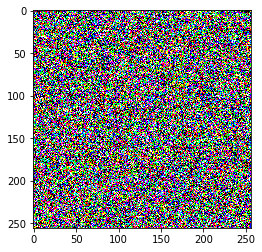

In [125]:
#create blank image
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/100
x = rand_img(style_shp)
plt.imshow(x[0])
plt.show()

# Experimenting
## Here we try different layer for content and style loss . and then compare results

In [126]:
#load all the layer in dict
conv_layers={}
for layer in model.layers:
    if type(layer) is Convolution2D:
        conv_layers[layer.name] = layer.output
        print(layer.name)

block1_conv1
block1_conv2
block2_conv1
block2_conv2
block3_conv1
block3_conv2
block3_conv3
block4_conv1
block4_conv2
block4_conv3
block5_conv1
block5_conv2
block5_conv3


In [127]:
#block3_conv1 for content and all 13 layers for style
#1 layer for content loss and 13 layers for style loss
content_layer_5 = conv_layers['block3_conv1']
style_layers_13 = [conv_layers[layer_name] for layer_name in conv_layers]

#block4_conv2 and 2 layer of each five blocks
#1 layer for content loss and 5 layers for style loss

content_layer_9 = conv_layers['block4_conv2']
style_layers_5 = [conv_layers['block{}_conv2'.format(o)] for o in range(1,6)]

In [128]:
#creating model for layers
content_model_5 = Model(model.input,content_layer_5)
style_model_13 = Model(model.input,style_layers_13)

content_model_9 = Model(model.input,content_layer_9)
style_model_5 = Model(model.input,style_layers_5)

In [129]:
#actual label for our optimizer
content_target_5 = K.variable(content_model_5.predict(source))
style_target_13 = [K.variable(output) for output in style_model_13.predict(style_)]

content_target_9 = K.variable(content_model_9.predict(source))
style_target_5 = [K.variable(output) for output in style_model_5.predict(style_)]
print("done")

done


In [214]:
#trying two different weights for style loss
layer_weights_1 = [0.05,0.2,0.2,0.25,0.3]
layer_weights_2 = [0.5,1.0,1.5,3.0,4.0]
no_weights = [1,1,1,1,1]

In [227]:
content_loss_5 = metrics.mse(content_layer_5,content_target_5)
style_loss_13 = sum(style_loss(layer[0],target[0])*w
                   for layer,target,w in zip(style_layers_13,style_target_13,layer_weights_1))/13


content_loss_9 = metrics.mse(content_layer_9,content_target_9)
style_loss_5 = sum(style_loss(layer[0],target[0])*w
                   for layer,target,w in zip(style_layers_5,style_target_5,layer_weights_1))/5

total_loss = 0.3*style_loss_13 + content_loss_5*0.8
total_loss_= 0.8*style_loss_5 + content_loss_9*0.3



grads = K.gradients(total_loss,model.input)
fn = K.function([model.input],[total_loss]+grads)
evaluator = Evaluator(fn,style_shp)



grads_1 = K.gradients(total_loss_,model.input)
fn_1 = K.function([model.input],[total_loss_]+grads_1)
evaluator_ = Evaluator(fn_1,style_shp)

In [228]:
iters = 10
x = solve_image(evaluator, iters, x,5)

Current loss:  3.87843e+12
Current loss:  3.90954e+12
Current loss:  3.8686e+12
Current loss:  3.93786e+12
Current loss:  3.92106e+12
Current loss:  3.86773e+12
Current loss:  3.8602e+12
Current loss:  3.93823e+12
Current loss:  3.92242e+12
Current loss:  3.95111e+12


In [229]:
x_1 = solve_image(evaluator_, iters, x,9)

Current loss:  8.50256e+13
Current loss:  6.82758e+13
Current loss:  5.80918e+13
Current loss:  5.43452e+13
Current loss:  5.53005e+13
Current loss:  5.7307e+13
Current loss:  4.95016e+13
Current loss:  4.60514e+13
Current loss:  4.44239e+13
Current loss:  4.42653e+13


In [230]:
print("h")

h


# 1> with using layer_weights_1 and style_loss_weights = 10 and 
# content_weight = 1
# 2> with layer_weights_2 
# 3> with no_weights

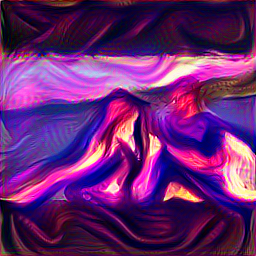

In [194]:
#case 1
path = 'results/res3_{}_{}.png'
#final image for 13 style layer
Image.open(path.format(9,5))

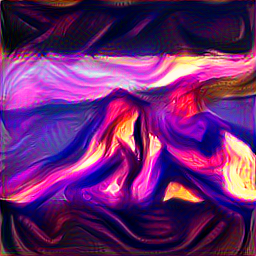

In [195]:
#final image for 5 layer style layer
Image.open((path.format(9,9)))

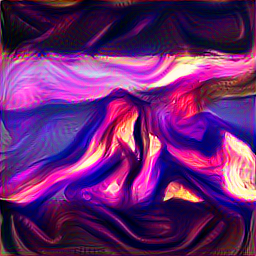

In [196]:
#case 2
path = 'results/res4_{}_{}.png'
#final image for 13 style layer
Image.open((path.format(9,5)))

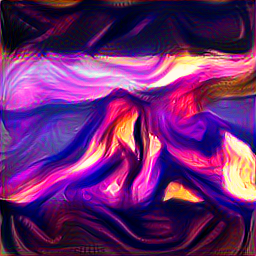

In [197]:
#final image for 5 layer style layer
Image.open((path.format(9,9)))

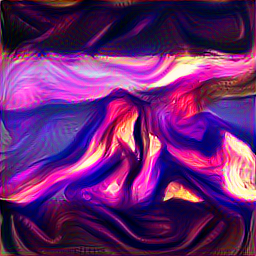

In [210]:
#case 3
path = 'results/res5_{}_{}.png'
#final image for 13 style layer
Image.open((path.format(9,5)))

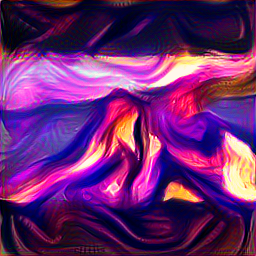

In [211]:
#final image for 5 layer style layer
Image.open((path.format(9,9)))

# 1>with layer_weight_1 , style_loss_weight = 9 and content_loss_weight = 2
# 2> with style_loss_weight = 6 and content_loss_4

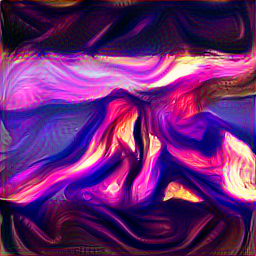

In [212]:
#case 1
path = 'results/res6_{}_{}.png'
#final image for 13 style layer
Image.open((path.format(9,5)))

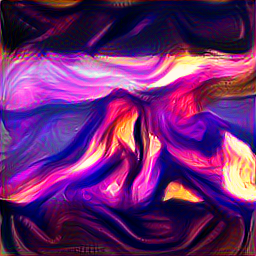

In [231]:
#case 2
path = 'results/res7_{}_{}.png'
#final image for 5 style layer
Image.open((path.format(9,9)))


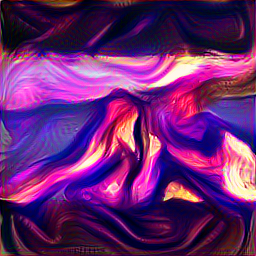

In [232]:

Image.open((path.format(9,5)))